In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import load_logging_data, create_lstm_dataset
from utils.ForecastModel import regression_model, predict_model_v4
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [2]:
train_dataset = load_logging_data(data_root_path='data/train')
val_dataset = load_logging_data(data_root_path='data/val')

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_dataset['Data_Type'] = 'train'
val_dataset['Data_Type'] = 'validation'

dataset = pd.concat([train_dataset, val_dataset], axis=0)
dataset.reset_index(drop=True, inplace=True)

In [4]:
dataset

,Time 1 - default sample rate,BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 2 CH=151,MX840B_CH 3 CH=152,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation


In [5]:
angle_name_list = list(dataset.columns)[22:24] + list(dataset.columns)[26:28]
print(angle_name_list)

pressure_name_list = list(dataset.columns)[18:20] + list(dataset.columns)[24:26]
print(pressure_name_list)

new_angle_name_list = ['Mast_X(deg)', 'Mast_Y(deg)', 'Base_X(deg)', 'Base_Y(deg)']
new_pressure_name_list = ['P1(bar)', 'P2(bar)', 'P3(bar)', 'P4(bar)']

dataset.rename(columns={'Time  1 - default sample rate': 'Time(sec)'}, inplace=True)
dataset.rename(columns={'caloutput_drill_depth CH=26': 'Drill_Depth(m)'}, inplace=True)
dataset.rename(columns={'caloutput_rotate_velocity CH=25': 'Drill_Rotation(RPM)'}, inplace=True)

for angle_name, new_angle_name in zip(angle_name_list, new_angle_name_list):
    dataset.rename(columns={angle_name: new_angle_name}, inplace=True)

for pressure_name, new_pressure_name in zip(pressure_name_list, new_pressure_name_list):
    dataset.rename(columns={pressure_name: new_pressure_name}, inplace=True)

dataset['Work_Load'] = (dataset[new_pressure_name_list[0]] * (dataset['Drill_Rotation(RPM)']))
dataset['Drill_Depth(m)'] = dataset['Drill_Depth(m)']/10

['angle_Mast_X CH=27', 'angle_Mast_Y CH=28', 'angle_base_X CH=31', 'angle_base_Y CH=32']
['pressure_1_pressure_transmitter_1_drive1 CH=23', 'pressure_1_pressure_transmitter_2_drive2 CH=24', 'pressure_2_pressure_transmitter_6_cyl_1 CH=29', 'pressure_3_pressure_transmitter_7_cyl_2 CH=30']


In [6]:
dataset['Work_Load'].describe()

count    21374.000000
mean       530.890803
std        581.121997
min          0.000000
25%          0.000000
50%        337.500000
75%        919.840000
max       4087.310000
Name: Work_Load, dtype: float64

In [7]:
for angle_name in new_angle_name_list:
    dataset[angle_name] = dataset[angle_name].clip(lower=-3, upper=3)

dataset[new_angle_name_list].describe()

,Mast_X(deg),Mast_Y(deg),Base_X(deg),Base_Y(deg)
count,21374.000000,21374.000000,21374.000000,21374.000000
mean,0.248030,-0.842360,-0.633260,0.007285
std,0.274738,0.390338,0.199366,0.318868
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,0.200000,-0.900000,-0.700000,-0.100000
50%,0.300000,-0.800000,-0.700000,0.100000
75%,0.400000,-0.700000,-0.600000,0.200000
max,3.000000,0.900000,1.800000,1.400000


In [8]:
diff_p1_df = np.concatenate([np.array([0]), np.diff(dataset[new_pressure_name_list[0]])], axis=0)
diff_p1_df = pd.DataFrame(diff_p1_df, columns=['Diff_p1(bar)'])

dataset = pd.concat([dataset, diff_p1_df], axis=1)
dataset.reset_index(drop=True, inplace=True)

In [9]:
#for angle_name in new_angle_name_list:
#    dataset[angle_name] = (dataset[angle_name] + 3) / 6

#for pressure_name in new_pressure_name_list:
#    dataset[pressure_name] = dataset[pressure_name] / 260

#dataset['Drill_Rotation(RPM)'] = dataset['Drill_Rotation(RPM)'] / 50

#dataset['Diff_Time(sec)'] = dataset['Diff_Time(sec)'] * 10
#dataset['Diff_p1(bar)'] = (dataset['Diff_p1(bar)']+220)/400

In [10]:
dataset['Work_Load'] = dataset['Work_Load']/4100

In [11]:
feature_name_list = new_angle_name_list + [new_pressure_name_list[0]] + ['Diff_p1(bar)', 'Drill_Rotation(RPM)']
target_name = 'Work_Load'

train_extract_dataset = dataset[dataset['Data_Type']=='train'][feature_name_list+[target_name]]
val_extract_dataset = dataset[dataset['Data_Type']=='validation'][feature_name_list+[target_name]]

dataset[feature_name_list+[target_name]].describe()

,Mast_X(deg),Mast_Y(deg),Base_X(deg),Base_Y(deg),P1(bar),Diff_p1(bar),Drill_Rotation(RPM),Work_Load
count,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000
mean,0.248030,-0.842360,-0.633260,0.007285,77.769754,-0.000032,6.226958,0.129486
std,0.274738,0.390338,0.199366,0.318868,30.197948,8.213618,7.010610,0.141737
min,-3.000000,-3.000000,-3.000000,-3.000000,19.350000,-212.950000,0.000000,0.000000
25%,0.200000,-0.900000,-0.700000,-0.100000,63.430000,-1.350000,0.000000,0.000000
50%,0.300000,-0.800000,-0.700000,0.100000,77.000000,0.000000,4.000000,0.082317
75%,0.400000,-0.700000,-0.600000,0.200000,88.530000,1.350000,10.000000,0.224351
max,3.000000,0.900000,1.800000,1.400000,255.350000,174.970000,50.000000,0.996905


In [12]:
pred_distance = 0
seq_len = 20

train_feature, train_target = create_lstm_dataset(train_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=train_extract_dataset.shape[1]-1)
val_feature, val_target = create_lstm_dataset(val_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=val_extract_dataset.shape[1]-1)

creating LSTM dataset...:   0%|          | 0/15995 [00:00<?, ?it/s]

creating LSTM dataset...:   0%|          | 0/5379 [00:00<?, ?it/s]

In [13]:
print(train_feature.shape, train_target.shape)
print(val_feature.shape, val_target.shape)

(15976, 20, 7) (15976,)
(5360, 20, 7) (5360,)


In [14]:
reg_model = regression_model(n_of_features=train_feature.shape[2], seq_len=seq_len)
reg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 7)]           0         
                                                                 
 conv1d (Conv1D)             (None, 18, 32)            704       
                                                                 
 batch_normalization_1 (Batc  (None, 18, 32)           128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 18, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            6208      
                                                                 
 batch_normalization_2 (Batc  (None, 16, 64)           256       
 hNormalization)                                             

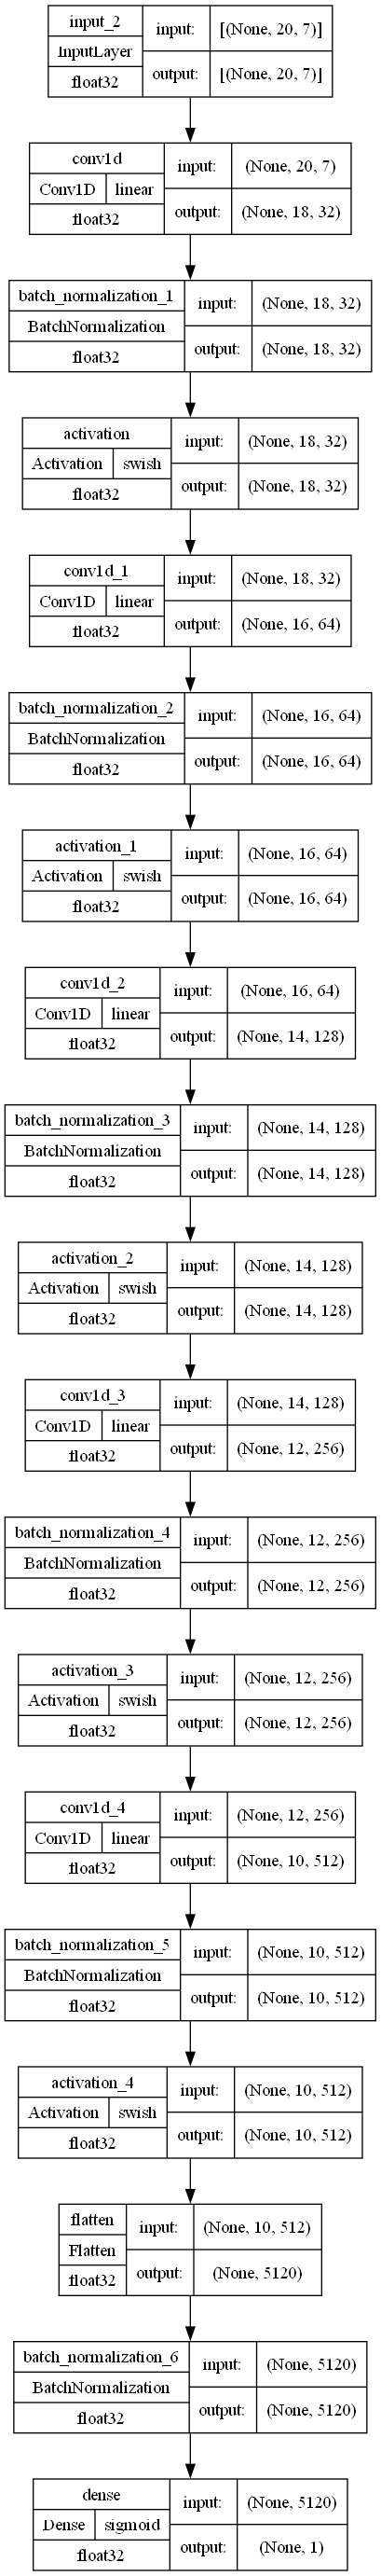

In [15]:
keras.utils.plot_model(reg_model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, verbose=0)
csv_logger = keras.callbacks.CSVLogger(filename=f'log_{pred_distance}_regression_model.csv', append=False, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath=f'reg_model_{pred_distance}.keras', monitor="val_loss", verbose=0,
                                                  save_best_only=True, save_weights_only=False, mode="min", save_freq="epoch",
                                                  initial_value_threshold=None)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + 'regression'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
reg_model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=10000000,
               batch_size=30000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point, tensorboard_callback])

In [18]:
best_reg_model = keras.models.load_model('reg_model_0.keras')
model_log = pd.read_csv(f'log_{pred_distance}.csv')

In [19]:
train_pred = np.squeeze(best_reg_model.predict(train_feature, verbose=1))
val_pred = np.squeeze(best_reg_model.predict(val_feature, verbose=1))

168/168 [==============================] - 0s 3ms/step


<Axes: >

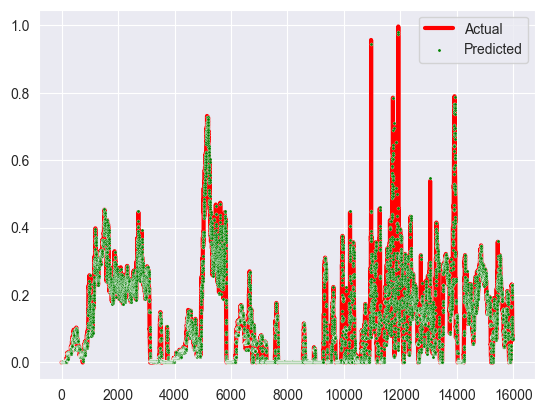

In [20]:
sns.lineplot(train_target, label='Actual', color='red', linewidth=3)
time_arr = np.arange(len(train_target))
sns.scatterplot(x=time_arr, y=train_pred, label='Predicted', color='green', s=5, zorder=2)

<Axes: >

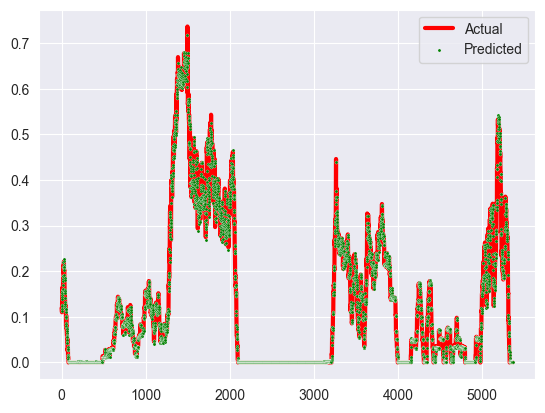

In [21]:
sns.lineplot(val_target, label='Actual', color='red', linewidth=3)
time_arr = np.arange(len(val_target))
sns.scatterplot(x=time_arr, y=val_pred, label='Predicted', color='green', s=5, zorder=2)

In [22]:
print(r2_score(val_target, val_pred))
print(mean_absolute_error(val_target, val_pred))
print(mean_absolute_percentage_error(val_target, val_pred))

0.9994287170810066
0.002373616934693525
2750860952676.891


Text(0, 0.5, 'Loss')

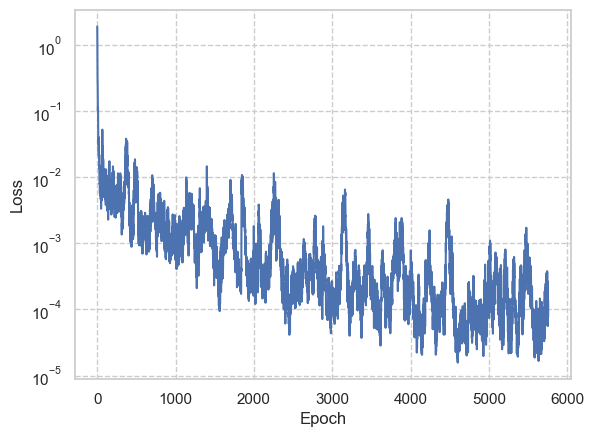

In [23]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(data=model_log, x='epoch', y='loss')

#plt.xlim(0, 3000)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend(['Train Loss', 'Validation Loss'])

Text(0, 0.5, 'Mean Absolute Error')

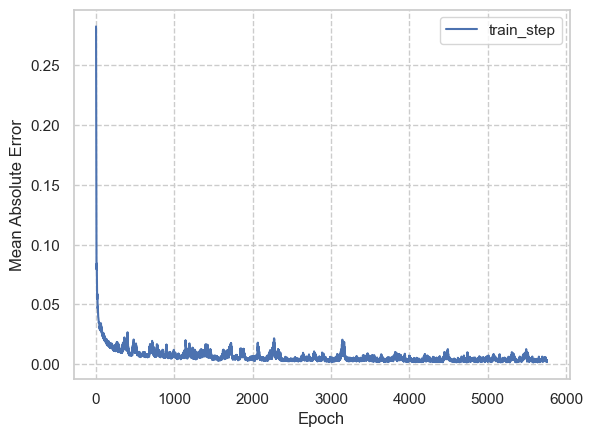

In [24]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(data=model_log, x='epoch', y='mean_absolute_error', label='train_step')

#plt.xlim(0, 3000)
plt.xlabel('Epoch')
#plt.yscale('log')
plt.ylabel('Mean Absolute Error')

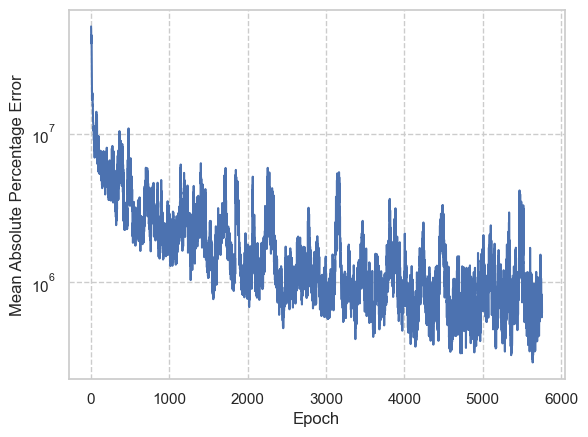

In [25]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(data=model_log, x='epoch', y='mean_absolute_percentage_error')

#plt.xlim(0, 3000)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Percentage Error')
plt.yscale('log')
#plt.legend(['Train Loss', 'Validation Loss'])

(0.0, 1.0)

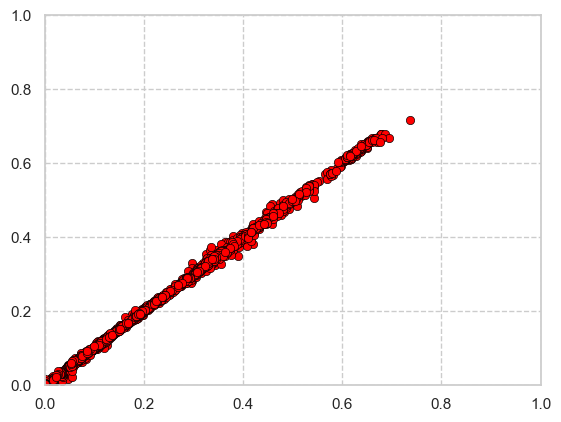

In [26]:
sns.scatterplot(x=val_target, y=val_pred, color='red', edgecolor='black')

plt.xlim(0, 1)
plt.ylim(0, 1)

<Axes: >

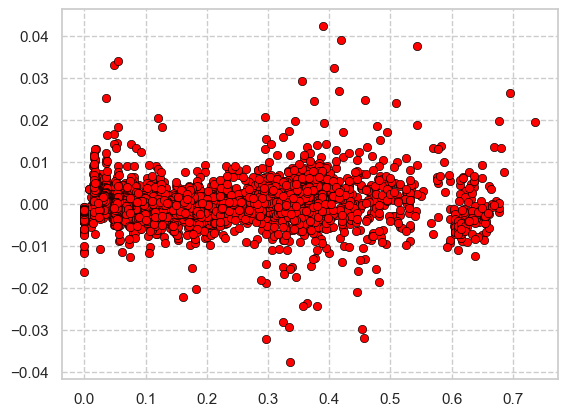

In [27]:
sns.scatterplot(x=val_target, y=val_target-val_pred, color='red', edgecolor='black')


In [28]:
seq_len = 20
pred_distance = 10
hidden_size = 512

train_feature, train_target = create_lstm_dataset(train_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=train_extract_dataset.shape[1]-1)
val_feature, val_target = create_lstm_dataset(val_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=val_extract_dataset.shape[1]-1)

creating LSTM dataset...:   0%|          | 0/15985 [00:00<?, ?it/s]

creating LSTM dataset...:   0%|          | 0/5369 [00:00<?, ?it/s]

In [29]:
predict_model = predict_model_v4(reg_model_path='reg_model_0.keras', n_of_features=train_feature.shape[2], seq_len=seq_len, hidden_size=hidden_size)
predict_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 7)]      0           []                               
                                                                                                  
 model (Functional)             (None, 1)            553473      ['input_3[0][0]']                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 20, 1)        0           ['model[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 20, 8)        0           ['input_3[0][0]',                
                                                                  'repeat_vector[0][0]']    

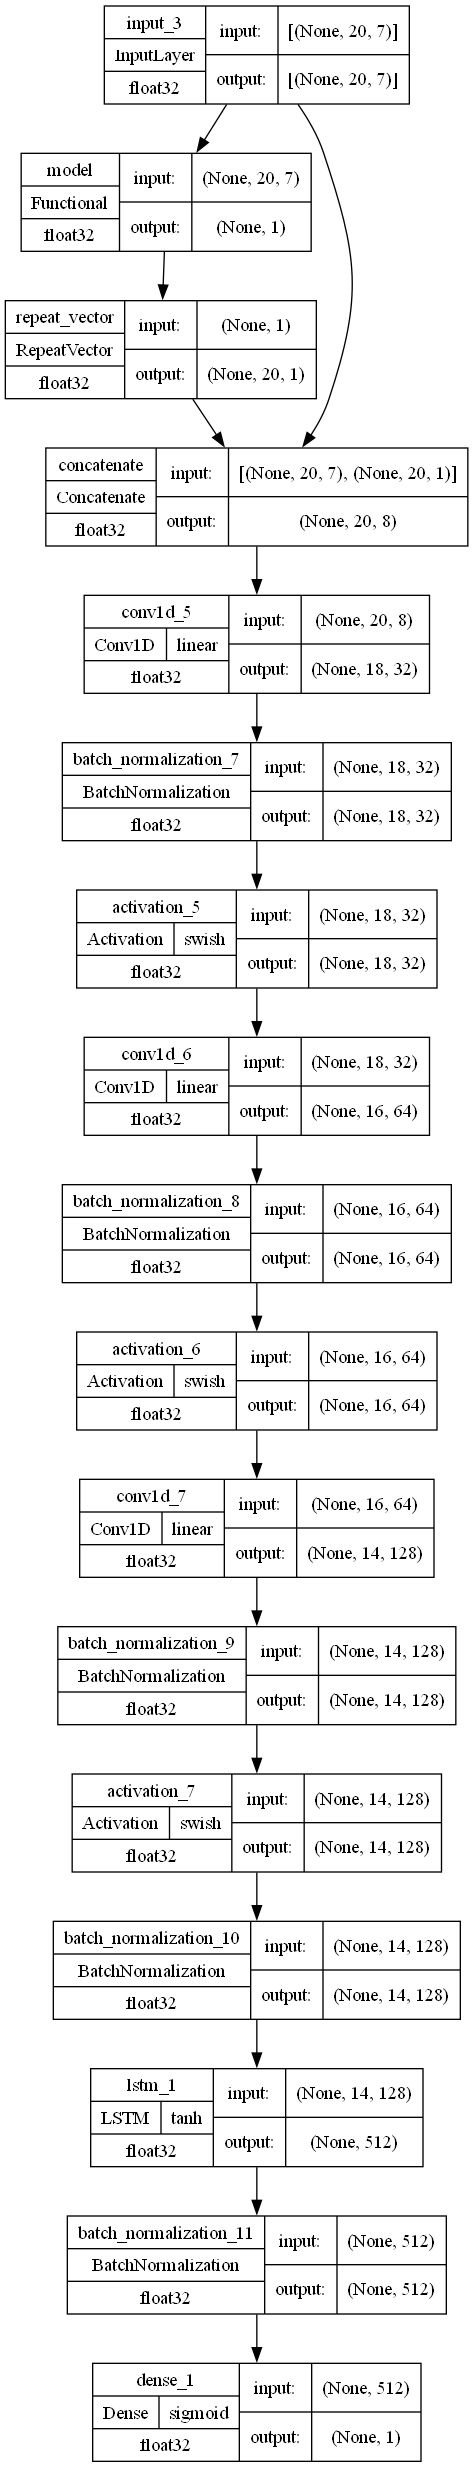

In [30]:
keras.utils.plot_model(predict_model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [31]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, verbose=0)
csv_logger = keras.callbacks.CSVLogger(filename='log_'+str(pred_distance)+'_of_predict_model.csv', append=False, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath=f'predict_model_{pred_distance}.keras', monitor="val_loss", verbose=0,
                                                  save_best_only=True, save_weights_only=False, mode="min", save_freq="epoch",
                                                  initial_value_threshold=None)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f'_pred_model_{pred_distance}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
predict_model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=10000000,
                  batch_size=30000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point, tensorboard_callback])

In [33]:
best_predict_model = keras.models.load_model(f'predict_model_{pred_distance}.keras')
model_log = pd.read_csv(f'log_{pred_distance}.csv')

In [34]:
train_pred = np.squeeze(best_predict_model.predict(train_feature, verbose=1))

499/499 [==============================] - 3s 6ms/step


In [35]:
print(r2_score(train_target, train_pred))
print(mean_absolute_error(train_target, train_pred))
print(mean_absolute_percentage_error(train_target, train_pred))

0.8142208038584102
0.03856062529073032
28863263167854.29


In [37]:
val_pred = np.squeeze(best_predict_model.predict(val_feature, verbose=1))

168/168 [==============================] - 1s 7ms/step


In [38]:
print(r2_score(val_target, val_pred))
print(mean_absolute_error(val_target, val_pred))
print(mean_absolute_percentage_error(val_target, val_pred))

0.9489206041396506
0.02448694169248595
16498478183078.525


In [39]:
from matplotlib.ticker import LogLocator, MultipleLocator

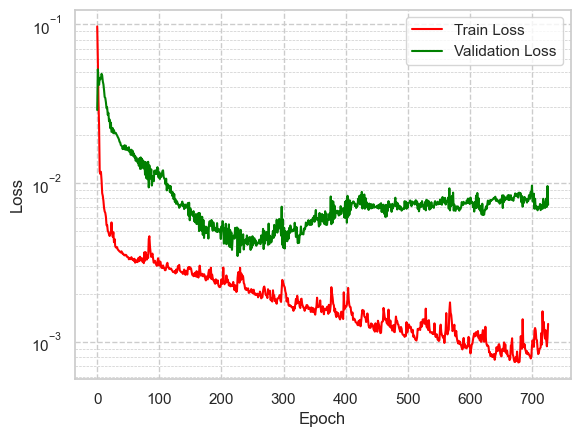

In [40]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

axis = sns.lineplot(data=model_log, x='epoch', y='loss', color='red', label='Train Loss')
sns.lineplot(data=model_log, x='epoch', y='val_loss', color='green', label='Validation Loss')

axis.yaxis.set_major_locator(MultipleLocator(100))

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True, which='minor', linestyle='--', linewidth=0.5)


Text(0, 0.5, 'Power')

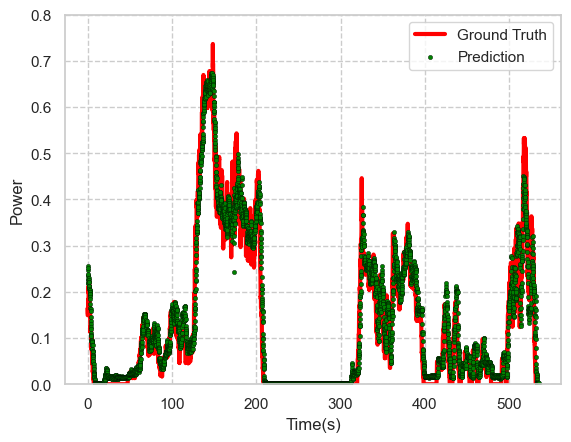

In [41]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=np.arange(val_target.shape[0])/10, y=val_target, label='Ground Truth', color='red', linewidth=3, zorder=1)
sns.scatterplot(x=np.arange(val_pred.shape[0])/10, y=val_pred, label='Prediction', color='green', edgecolor='black', zorder=2, s=10)

plt.xlabel('Time(s)')
plt.ylim(0, 0.8)
plt.ylabel('Power')

Text(0, 0.5, 'power')

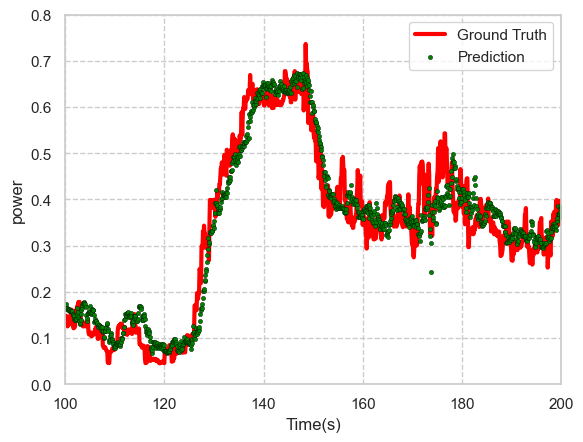

In [42]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=np.arange(val_target.shape[0])/10, y=val_target, label='Ground Truth', color='red', linewidth=3, zorder=1)
sns.scatterplot(x=np.arange(val_pred.shape[0])/10, y=val_pred, label='Prediction', color='green', edgecolor='black', zorder=2, s=10)

plt.xlim(100, 200)
plt.xlabel('Time(s)')
plt.ylim(0, 0.8)
plt.ylabel('power')

Text(0, 0.5, 'power')

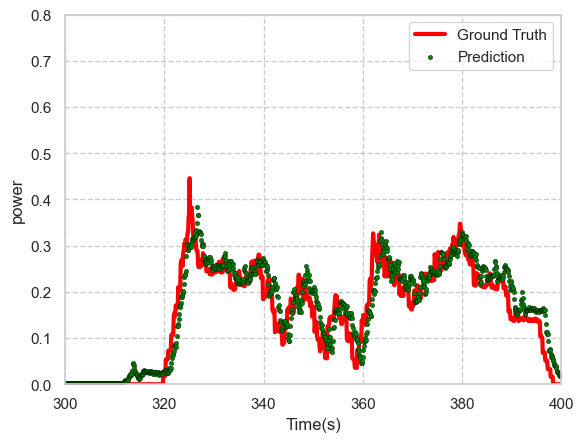

In [43]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=np.arange(val_target.shape[0])/10, y=val_target, label='Ground Truth', color='red', linewidth=3, zorder=1)
sns.scatterplot(x=np.arange(val_pred.shape[0])/10, y=val_pred, label='Prediction', color='green', edgecolor='black', zorder=2, s=10)

plt.xlim(300, 400)
plt.xlabel('Time(s)')
plt.ylim(0, 0.8)
plt.ylabel('power')

Text(0, 0.5, 'power')

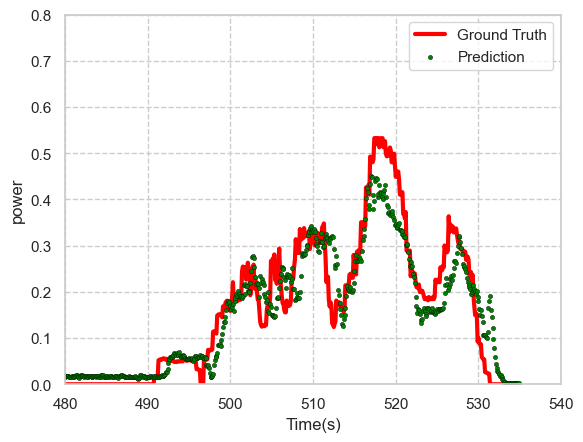

In [44]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=np.arange(val_target.shape[0])/10, y=val_target, label='Ground Truth', color='red', linewidth=3, zorder=1)
sns.scatterplot(x=np.arange(val_pred.shape[0])/10, y=val_pred, label='Prediction', color='green', edgecolor='black', zorder=2, s=10)

plt.xlim(480, 540)
plt.xlabel('Time(s)')
plt.ylim(0, 0.8)
plt.ylabel('power')

(0.0, 1.0)

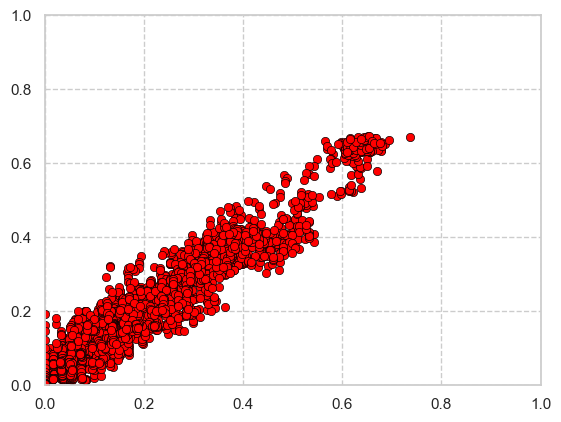

In [45]:
sns.scatterplot(x=val_target, y=val_pred, color='red', edgecolor='black')

plt.xlim(0, 1)
plt.ylim(0, 1)

<Axes: >

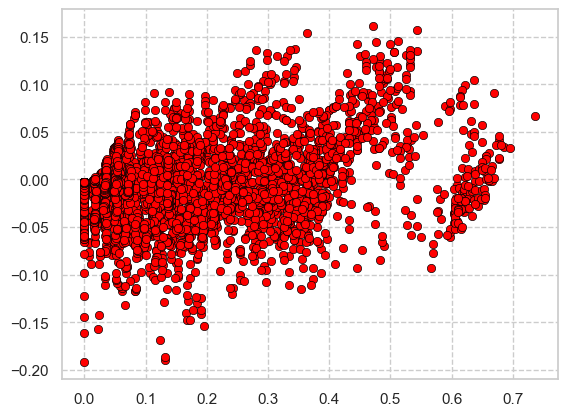

In [46]:
sns.scatterplot(x=val_target, y=val_target-val_pred, color='red', edgecolor='black')


In [47]:
val_result_df = pd.DataFrame({'val_target': val_target, 'val_pred': val_pred,'relative_error': (np.abs(val_target-val_pred)/val_target)*100})
val_result_df = val_result_df[val_result_df['val_target'] != 0]
val_result_df.reset_index(drop=True, inplace=True)

val_result_df['relative_error'] = val_result_df['relative_error']

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_40848\2451571244.py:1: RuntimeWarning: divide by zero encountered in divide
  val_result_df = pd.DataFrame({'val_target': val_target, 'val_pred': val_pred,'relative_error': (np.abs(val_target-val_pred)/val_target)*100})


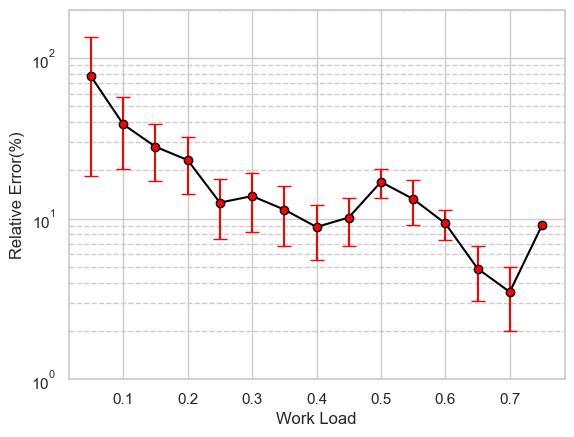

In [52]:
est_result = []
refine_val_result = []
load_range = np.array(range(0, 20, 1))
load_range = load_range/20


for idx in range(len(load_range)-1):
    flow_df = val_result_df[(val_result_df['val_target'] >= load_range[idx]) & (val_result_df['val_target'] < load_range[idx+1])]
    flow_df.reset_index(drop=True, inplace=True)
    refine_val_result.append(flow_df)

for val in refine_val_result:
    est_result.append([val['relative_error'].mean(), val['relative_error'].std()])

est_result = np.array(est_result)
est_result = pd.DataFrame(np.hstack([load_range[1:].reshape(-1, 1), est_result]),
                           columns=['Load', 'Mean Relative Error(%)', 'Std Relative Error(%)'])


sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})


plt.errorbar(est_result['Load'], y=est_result['Mean Relative Error(%)'], yerr=est_result['Std Relative Error(%)']/2,
             marker='o', markeredgecolor='black', markerfacecolor='red', capsize=5, color='black', ecolor='red')

plt.xlabel('Work Load')

plt.yscale('log')
plt.ylim(1, 200)
plt.ylabel('Relative Error(%)')

plt.grid(True, which='major', linestyle='-', linewidth=1.0)
plt.grid(True, which='minor', linestyle='--', linewidth=1.0)